# ML pipeline

## Dataset Information

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

**Source:** https://archive.ics.uci.edu/dataset/1/abalone

#### Additional Information

Abalone are a type of sea snail, a gastropod mollusc, that grows in coastal seawater. Members of the Haliotidae family, they range in size from 4 to 10 inches (10 to 25 cm). These marine creatures have a single shell on top with a large foot underneath, which is used for moving and eating. The shell is flat and spiral-shaped, with several small holes around its perimeter, and it is lined with mother of pearl, which is sought after for button, trinket and jewellery making.

**Source:** https://asc-aqua.org/learn-about-seafood-farming/farmed-abalone/

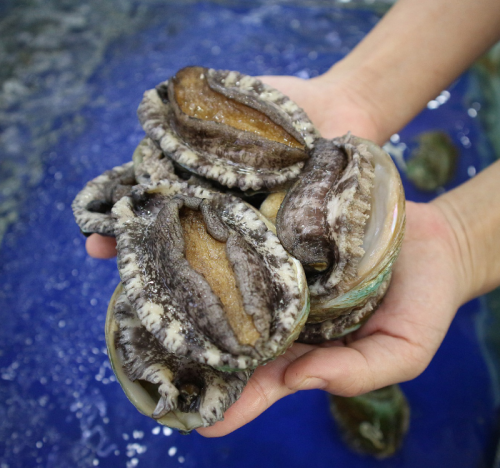

**Source:** https://api.minapoli.com/media/infomina/p/medium_f4bb3b54003788adcfd8cd616fcd9b01.png

## Data Preparation

### Data Loading

In [ ]:
# Data Analysis & Visualization
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
import pickle
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

# Metrics
from sklearn import metrics

In [ ]:
abalone_data = "https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/abalone.csv"

In [ ]:
df = pd.read_csv(abalone_data)

### Data Description



*   `Sex` - nominal - M, F, and I (infant)
*   `Length` - continuous - mm - Longest shell measurement
*   `Diameter` - continuous - mm - perpendicular to length
*   `Height` - continuous - mm - with meat in shell
*   `Whole weight` - continuous - grams - whole abalone
*   `Shucked weight` - continuous - grams - weight of meat
*   `Viscera weight` - continuous - grams - gut weight (after bleeding)
*   `Shell weight` - continuous - grams - after being dried
*   `Rings` - integer - +1.5 gives the age in years (target)

[Pandas cheatsheet](https://images.datacamp.com/image/upload/v1676302204/Marketing/Blog/Pandas_Cheat_Sheet.pdf)

In [ ]:
df.head()  # returns the first 5 rows (default)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Dataset Characteristics

**DataFrame dimensionality (n rows, n columns)**

In [ ]:
df.shape

(4177, 9)

**Information about the DataFrame (index dtype and columns, non-null values and memory usage)**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


**Comments:**

Missing values found in the **Diameter**, **Whole weight** and **Shell weight** columns (4177 - 4078 = 99 rows).

### Data Preprocessing

#### Rename Columns

In [ ]:
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [ ]:
# Whitespace in feature_names, replace with underlines
df.rename(columns={'Whole weight': 'Whole_weight',
                   'Shucked weight': 'Shucked_weight',
                   'Viscera weight': 'Viscera_weight',
                   'Shell weight': 'Shell_weight'}, inplace=True)

df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

#### Misspelled values

In [ ]:
# Return a Series containing the frequency of each distinct row in the Dataframe
df.Sex.value_counts()

Sex
M    1447
I    1276
F    1259
f     195
Name: count, dtype: int64

**Comments:**

From the data description, we know that the '**Sex**' column has three categories - **M, F,** and **I** (infant). During the data exploration (above), two variants of the female gender designation were found - **F** (1259 values) and **f** (195 values), respectively. Let's replace **f** with **F** to combine data related to the same gender.

In [ ]:
df['Sex'] = df['Sex'].replace('f', 'F')
df.Sex.value_counts()

Sex
F    1454
M    1447
I    1276
Name: count, dtype: int64

#### Duplicates

In [ ]:
df.duplicated().sum()

0

**Comments:**

No duplicate rows found.

#### Missing values

In [ ]:
df.isnull().mean() * 100

Sex               0.000000
Length            0.000000
Diameter          2.370122
Height            0.000000
Whole_weight      2.370122
Shucked_weight    0.000000
Viscera_weight    0.000000
Shell_weight      1.197031
Rings             0.000000
dtype: float64

**Comments:**

The missing values in the **Diameter, Whole weight** and **Shell weight** columns are **1-2%**, so next we will fill them with the median values, because median is resistant to outliers:

In [ ]:
diameter_median = df["Diameter"].median()
df["Diameter"].fillna(diameter_median, inplace=True)
diameter_median

0.425

In [ ]:
whole_wt_median = df["Whole_weight"].median()
df["Whole_weight"].fillna(whole_wt_median, inplace=True)
whole_wt_median

0.7985

In [ ]:
shell_wt_median = df["Shell_weight"].median()
df["Shell_weight"].fillna(shell_wt_median, inplace=True)
shell_wt_median

0.235

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df[(df == 0).any(axis=1)]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


**Comments:**

In two cases, the values of **Height** are $=0.0$, with filled values in the **Length** and **Diameter** columns (the values differ significantly from 0), which looks confusing. Let's replace these values with medians:

In [ ]:
height_median = df.Height.median()
height_median

0.14

In [ ]:
df['Height'] = df['Height'].replace(0.0, height_median)

In [ ]:
df.iloc[[1257, 3996]]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.430,0.34,0.14,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.14,0.134,0.0575,0.0285,0.3505,6


In [ ]:
df[(df == 0).any(axis=1)]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings


#### Target

*   `Rings` - integer - +1.5 gives the age in years (target)

**Comments:**

From the data description, we know that the target variable, **Age**, which is originally not represented in this dataset, can be obtained by adding 1.5 to each of the values in the **Rings** column.

In this case, we will not need the **Rings** column for further analysis.

In [ ]:
df["Age"] = df["Rings"] + 1.5
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.7985,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


In [ ]:
del df["Rings"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Age             4177 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


## Modeling

#### Methods

##### Metrics

**Root Mean Squared Error (RMSE)**

>

The RMSE measures the average difference between values predicted by a model and the actual values. It provides an estimation of how well the model is able to predict the target value (accuracy).

 The lower the value of the Root Mean Squared Error, the better the model is. A perfect model (a hypothetic model that would always predict the exact expected value) would have a Root Mean Squared Error value of 0.

The Root Mean Squared Error has the advantage of representing the amount of error in the same unit as the predicted column making it easy to interpret.

$$\text{RMSE}(P_i, O_i) = \sqrt{\frac{\sum_{i=1}^{N} (P_i - O_i)^2}{N}}$$

where

$P_i$ - the predicted value for the $i$-th observation,

$O_i$ - the observed (actual) value for the $i$-th observation,

$N$ - total number of observations.



$R^2 -$ **Coefficient of Determination**

>

R-Squared ($R^2$) is a statistical measure used to determine the proportion of variance in a dependent variable that can be predicted or explained by an independent variable.

An R-Squared value shows how well the model predicts the outcome of the dependent variable. R-Squared values range from 0 to 1.

An R-Squared value of 0 means that the model explains or predicts 0% of the relationship between the dependent and independent variables.

A value of 1 indicates that the model predicts 100% of the relationship, and a value of 0.5 indicates that the model predicts 50%, and so on.

The formula below is mostly used to find the value of R-Squared:

$$R^2 = 1 - \frac{RSS}{TSS}$$

where,

$R^2 -$ coefficient of determination,

$RSS -$ sum of squares of residuals,

$TSS -$ total sum of squares.

**References:**

https://help.sap.com/docs/SAP_PREDICTIVE_ANALYTICS/41d1a6d4e7574e32b815f1cc87c00f42/5e5198fd4afe4ae5b48fefe0d3161810.html?locale=en-US

https://www.geeksforgeeks.org/root-mean-square-error-in-r-programming/

https://www.freecodecamp.org/news/what-is-r-squared-r2-value-meaning-and-definition/

##### Feature Scaling

Distance-based algorithms, such as the KNN, calculate the distance between data points to determine their similarity.

Features with larger magnitudes can disproportionately influence the distance calculation, leading to biased results.

Feature scaling addresses this issue by transforming the features to a comparable range or scale, ensuring that each feature contributes fairly to the final result.



**MinMaxScaler**

>

Min-Max scaling transforms the features by scaling their values to a specific range, typically $[0, 1]$.

It is calculated using the formula:

>

$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

>

We subtract the minimum value from each feature and divide the result by the difference between the maximum and minimum values.

**StandardScaler**

>

Standardization does it by centering their values around the mean $(0)$ and scaling them based on the standard deviation.

The standard score of a sample $x$ is calculated as:

$$x_{scaled} = \frac{x - \mu}{\sigma}$$

>

where

$\mu$ is the mean of the training samples or zero if **with_mean=False**,

$\sigma$ is the standard deviation of the training samples or one if **with_std=False**.

>

**References:**

https://forecastegy.com/posts/is-feature-scaling-required-for-the-knn-algorithm/

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

##### Model Evaluation

In [ ]:
def model_eval(y_test, preds):

    mse = metrics.mean_squared_error(y_test, preds)

    rmse = np.sqrt(mse)
    print("Root Mean Square Error (RMSE): {0:.4}".format(rmse))

    # R² score (the coefficient of determination)
    r2 = metrics.r2_score(y_test, preds)
    print(f"R2 score: {round(r2, 4)}")

In [ ]:
def preds_plot(y_test, preds):

    plt.figure(figsize=(6,4))
    plt.scatter(y_test, preds, s=15, label="data")
    plt.plot(y_test, y_test, lw=1.25, c="red", label="predicted")
    plt.xlabel('Actual age, years', fontsize=10)
    plt.ylabel('Predicted age, years', fontsize=10)
    plt.title('Actual vs Predicted Age', fontsize=10)
    plt.legend()
    plt.show()

##### Data Splitting

In [ ]:
X = df.drop(["Sex", "Age"], axis=1)
y = df["Age"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### K-Nearest Neighbors (KNN) Regression

#### Default Parameters

In [ ]:
knr = Pipeline([('scaler', MinMaxScaler()),
                ('model', KNeighborsRegressor())])

knr.fit(X_train, y_train)

knr_preds = knr.predict(X_test)

In [ ]:
# KNN Regression Evaluation
model_eval(y_test, knr_preds)

Root Mean Square Error (RMSE): 2.29
R2 score: 0.5154


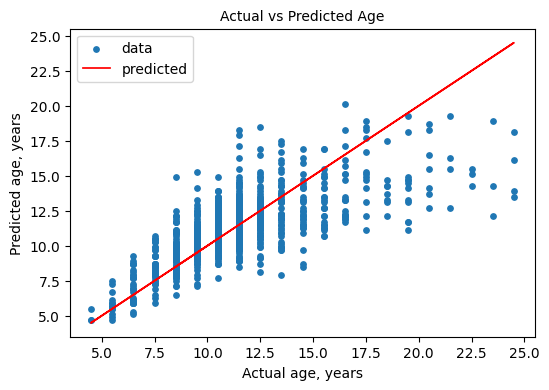

In [ ]:
# plot the predicted values against the true values
preds_plot(y_test, knr_preds)

**Comments:**

>

In KNeighborsRegressor model the target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

With the default parameters and Min-Max scaling, the RMSE and R2 scores (on the test set) are 2.29 and 0.5154, which are quite far from the ideal scores of 0 and 1, respectively. However, it should be taken into account that outliers previously detected in the EDA have not been removed (or replaced). In addition, almost all features (except 'Sex') have negatively or positively skewed distribution. All this could somehow affect the estimates.

Although, the feature magnitudes do not vary greatly across the dataset, MinMaxScaler slightly improved the RMSE and R2 of the KNeighborsRegressor model compared to the model without feature scaling (2.299 and 0.5118, respectively) and was better than Standardization (2.376 and 0.4786, respectively), results not shown.

**Reference:** https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

#### Hyperparameter Tuning

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('model', KNeighborsRegressor())])

params = {'model__n_neighbors' : np.arange(1,31),
          'model__weights' : ['uniform', 'distance'],
          'model__leaf_size' : range(1,52,10), 'model__p' : [1, 2]}

gs = GridSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=3)
gs.fit(X_train, y_train)

In [ ]:
gs.best_score_, gs.best_params_

(-2.1820912972452047,
 {'model__leaf_size': 1,
  'model__n_neighbors': 22,
  'model__p': 2,
  'model__weights': 'distance'})

In [ ]:
preds = gs.best_estimator_.predict(X_test)

# KNN Regression Evaluation
model_eval(y_test, preds)

Root Mean Square Error (RMSE): 2.22
R2 score: 0.5449


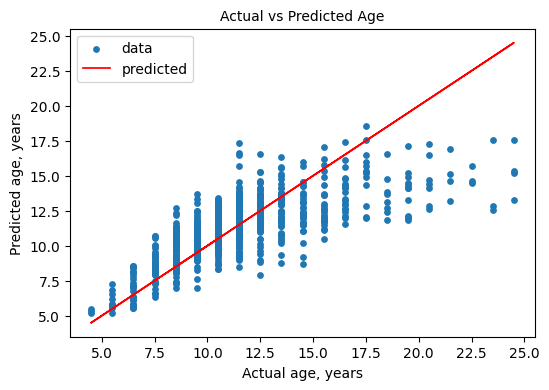

In [ ]:
# plot the predicted values against the true values
preds_plot(y_test, preds)

**Comments:**

>

Tuning the hyperparameters of the KNeighborsRegressor model improved the RMSE and R2 scores to 2.22 and 0.5449, respectively, although the scores are still low.

In addition to mentioned above (preprocessing of outliers and data normalization required), a more detailed analysis of the model's hyperparameters and their impact on the accuracy of the model could allow for better tuning of the KNN Regression model.

### Support Vector Regression (SVR)

#### Default Parameters

In [ ]:
esvr = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR())])

esvr.fit(X_train, y_train)

esvr_preds = esvr.predict(X_test)

In [ ]:
# SVR Evaluation
model_eval(y_test, esvr_preds)

Root Mean Square Error (RMSE): 2.265
R2 score: 0.5261


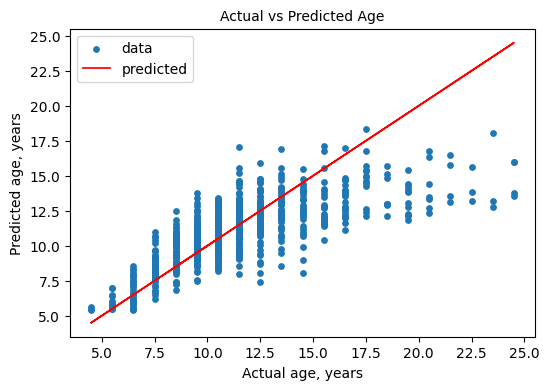

In [ ]:
# plot the predicted values against the true values
preds_plot(y_test, esvr_preds)

**Comments:**

>

Support vector regression (SVR) is a type of support vector machine (SVM) that tries to find a function that best predicts the continuous output value for a given input value. The main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.

With the default parameters and standardization, the RMSE and R2 scores (on the test set) are 2.265 and 0.5261, respectively. These results are slightly better than using KNN regression, but still not as good.

StandardScaler improved the RMSE and R2 of the SVR model compared to the model without feature scaling (2.324 and 0.5009, respectively) and was better than MinMaxScaler (2.314 and 0.5055, respectively), results not shown.


**References:**

https://www.geeksforgeeks.org/support-vector-regression-svr-using-linear-and-non-linear-kernels-in-scikit-learn/

https://www.saedsayad.com/support_vector_machine_reg.htm

#### Hyperparameter Tuning

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('model', SVR())])

params = {'model__C': [0.1, 1, 10, 100],
          'model__gamma': [0.01, 0.1, 1, 10],
          'model__epsilon': [0.01, 0.1, 0.5, 1]}

gs = GridSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', SVR())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__epsilon': [0.01, 0.1, 0.5, 1],
                         'model__gamma': [0.01, 0.1, 1, 10]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
gs.best_score_, gs.best_params_

(-2.135582843326481, {'model__C': 10, 'model__epsilon': 1, 'model__gamma': 10})

In [ ]:
preds = gs.best_estimator_.predict(X_test)

# SVR Evaluation
model_eval(y_test, preds)

Root Mean Square Error (RMSE): 2.196
R2 score: 0.5546


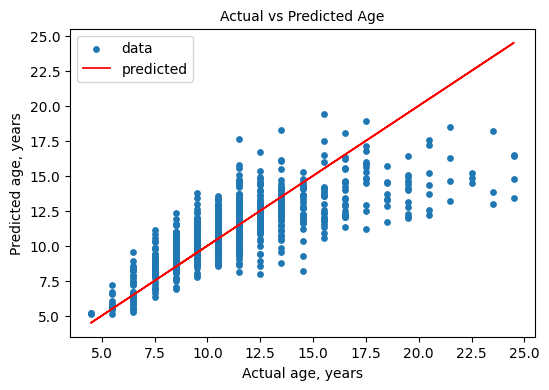

In [ ]:
# plot the predicted values against the true values
preds_plot(y_test, preds)

**Comments:**

Tuning the hyperparameters of the SVR model with MinMaxScaler improved the RMSE and R2 scores to 2.196 and 0.5546, respectively, that was better than Standartization (2.233 and 0.5392, respectively), results not shown. Again, this model performs better than KNN Regression, although it is still not perfect.

I used three hyperparameters in this case (and fairly limited range of their values), because my computing resources are  restricted and tuning the SVR model with more parameters (and their values over a wide range) requires more time and resources.

### Random Forest Regression (RFR)

#### Default Parameters

In [ ]:
rfr = Pipeline([('model', RandomForestRegressor())])

rfr.fit(X_train, y_train)

rfr_preds = rfr.predict(X_test)

In [ ]:
# RFR Evaluation
model_eval(y_test, rfr_preds)

Root Mean Square Error (RMSE): 2.274
R2 score: 0.5224


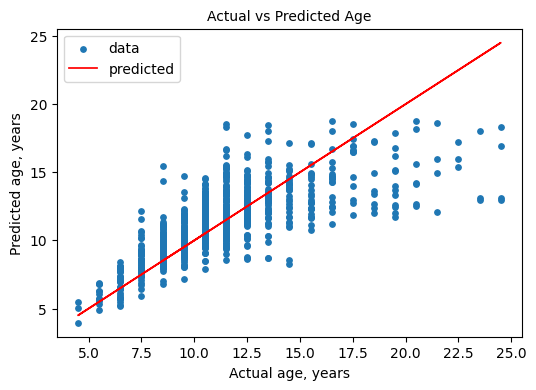

In [ ]:
# plot the predicted values against the true values
preds_plot(y_test, rfr_preds)

**Comments:**

Random Forest Regression is a versatile machine-learning technique for predicting numerical values. It combines the predictions of multiple decision trees to reduce overfitting and improve accuracy.

Random Forest is a tree-based model and hence does not require feature scaling. The RMSE and R2 scores (on the test set) are 2.26 and 0.5281, which are quite far from the ideal scores of 0 and 1, respectively. So, this model (with default parameters) performs slightly better than KNN regression and a bit worse than SVR.



**References:**

https://www.geeksforgeeks.org/random-forest-regression-in-python/

https://forecastegy.com/posts/does-random-forest-need-feature-scaling-or-normalization/

#### Hyperparameter Tuning

In [ ]:
pipe = Pipeline([('model', RandomForestRegressor())])

params = {"model__n_estimators" : [100, 250, 500, 1000],
          "model__max_depth": [None, 1, 10, 50, 100],
          "model__min_samples_leaf": [1, 3, 5, 10],
          "model__min_samples_split": [3, 6, 9, 12]}

gs = GridSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 1, 10, 50, 100],
                         'model__min_samples_leaf': [1, 3, 5, 10],
                         'model__min_samples_split': [3, 6, 9, 12],
                         'model__n_estimators': [100, 250, 500, 1000]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
gs.best_score_, gs.best_params_

(-2.134869937163309,
 {'model__max_depth': 10,
  'model__min_samples_leaf': 10,
  'model__min_samples_split': 3,
  'model__n_estimators': 250})

In [ ]:
preds = gs.best_estimator_.predict(X_test)

# RFR Evaluation
model_eval(y_test, preds)

Root Mean Square Error (RMSE): 2.23
R2 score: 0.5406


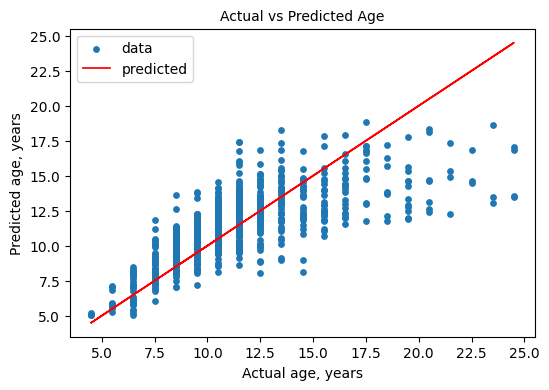

In [ ]:
# plot the predicted values against the true values
preds_plot(y_test, preds)

**Comments:**

Tuning the hyperparameters of the RFR model improved the RMSE and R2 scores to 2.23 and 0.5406, respectively. In this case, Random Forest Regression performs lower than tuned KNN Regression and SVR.

### Categorical + SVR

Since SVR performs slightly better than KNN Regression and RFR, I decided to use it for the final test with categorical data.

#### Data splitting

In [ ]:
X_full = df.drop('Age', axis=1)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=42)

In [ ]:
X_train_full.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
dtype: object

In [ ]:
X_train.shape

(3341, 7)

#### Data Transformation

In [ ]:
categorical = ['Sex']
numeric_features = ['Length', 'Diameter', 'Height', 'Whole_weight',
                    'Shucked_weight', 'Viscera_weight', 'Shell_weight']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', MinMaxScaler(), numeric_features)
])

X_train_transformed = ct.fit_transform(X_train_full)
X_test_transformed = ct.transform(X_test_full)

In [ ]:
new_features = list(ct.named_transformers_['ohe'].get_feature_names_out())
new_features.extend(numeric_features)

new_features

['Sex_F',
 'Sex_I',
 'Sex_M',
 'Length',
 'Diameter',
 'Height',
 'Whole_weight',
 'Shucked_weight',
 'Viscera_weight',
 'Shell_weight']

In [ ]:
X_train.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
4038,0.550,0.445,0.125,0.6720,0.2880,0.1365,0.210
1272,0.475,0.355,0.100,0.5035,0.2535,0.0910,0.140
3384,0.305,0.225,0.070,0.1485,0.0585,0.0335,0.045
3160,0.275,0.200,0.065,0.1165,0.0565,0.0130,0.035
3894,0.495,0.380,0.135,0.6295,0.2630,0.1425,0.235


In [ ]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_features)

X_train_transformed.head()

,Sex_F,Sex_I,Sex_M,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,0.0,1.0,0.0,0.641892,0.655462,0.102679,0.237294,0.193006,0.179065,0.207773
1,0.0,1.0,0.0,0.540541,0.504202,0.080357,0.177616,0.169805,0.119157,0.138017
2,1.0,0.0,0.0,0.310811,0.285714,0.053571,0.051886,0.038668,0.043450,0.043348
3,0.0,1.0,0.0,0.270270,0.243697,0.049107,0.040553,0.037323,0.016458,0.033383
4,0.0,0.0,1.0,0.567568,0.546218,0.111607,0.222242,0.176194,0.186965,0.232686


In [ ]:
X_train_transformed.shape

(3341, 10)

#### Default Parameters

In [ ]:
svr_ct = Pipeline([('model', SVR())])

svr_ct.fit(X_train_transformed, y_train_full)  # '_transformed' scaled with StandardScaler

svr_preds = svr_ct.predict(X_test_transformed)

In [ ]:
# SVR Evaluation
model_eval(y_test_full, svr_preds)

Root Mean Square Error (RMSE): 2.238
R2 score: 0.5375


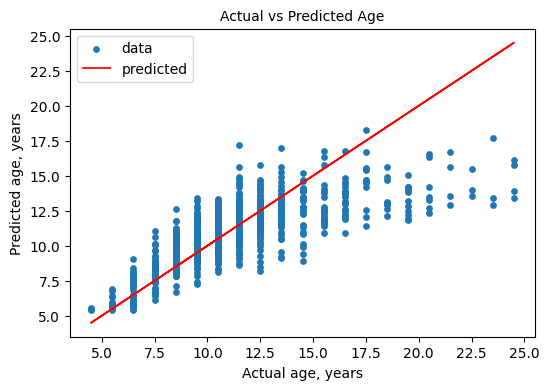

In [ ]:
# plot the predicted values against the true values
preds_plot(y_test_full, svr_preds)

**Comments:**

With the default parameters, standardization and categorical data, transformed with OneHotEncoder, the RMSE and R2 scores (on the test set) are 2.238 and 0.5375, respectively, these results are better among all models tested with default parameters above (without categorical data).

StandardScaler improved the RMSE and R2 of the SVR model compared to MinMaxScaler (2.373 and 0.4797, respectively), results not shown.

I didn't run the pipeline with OneHotEncoder (applied it in the data transformation step above), cause I had some issues with loading the model and data to Explainer Dashboard (there was a warning like: feature/column names cannot be extracted...).

#### Hyperparameter Tuning

In [ ]:
pipe = Pipeline([('model', SVR())])

params = {'model__C': [0.1, 1, 10, 100],
          'model__gamma': [0.01, 0.1, 1, 10],
          'model__epsilon': [0.01, 0.1, 0.5, 1]}

gs = GridSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=3)
gs.fit(X_train_transformed, y_train_full)  # '_transformed' scaled with MinMaxScaler

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', SVR())]), n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__epsilon': [0.01, 0.1, 0.5, 1],
                         'model__gamma': [0.01, 0.1, 1, 10]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
gs.best_score_, gs.best_params_

(-2.1476802627201796,
 {'model__C': 10, 'model__epsilon': 1, 'model__gamma': 10})

In [ ]:
preds = gs.best_estimator_.predict(X_test_transformed)

# SVR Evaluation
model_eval(y_test_full, preds)

Root Mean Square Error (RMSE): 2.203
R2 score: 0.5518


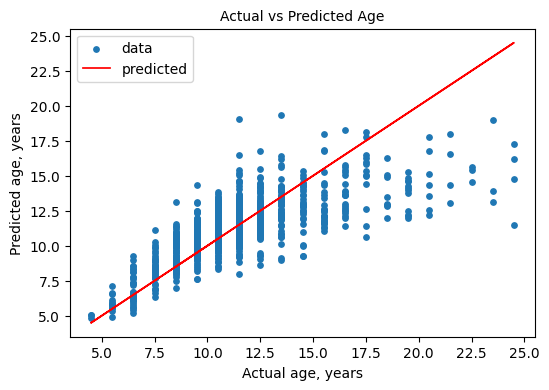

In [ ]:
# plot the predicted values against the true values
preds_plot(y_test_full, preds)

In [ ]:
# Save best estimator
pkl_filename = "svr_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(gs.best_estimator_, file)

# Load the model from file
with open(pkl_filename, 'rb') as file:
    svr_model = pickle.load(file)

In [ ]:
# Check predictions
svr_saved_preds = svr_model.predict(X_test_transformed)
model_eval(y_test_full, svr_saved_preds)

Root Mean Square Error (RMSE): 2.203
R2 score: 0.5518


**Comments:**

Tuning the hyperparameters of the SVR model with MinMaxScaler improved the RMSE and R2 scores to 2.203 and 0.5518, respectively, while using StandardScaler these scores were 2.22 and 0.5446, respectively, results not shown.

This model performes better than tuned KNN regression and RFR (without categorical data) and slightly worse than tuned SVR (without categorical data).


### Explainer Dashboard

In [ ]:
!pip install explainerdashboard -q

In [ ]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
explainer = RegressionExplainer(svr_model, X_test_transformed, y_test_full)

splitting pipeline...
Failed to retrieve new column names from transformer_pipeline.get_feature_names_out()!
transformer pipeline outputs a DataFrame with the same number of columnsso trying to assign column names from X.columns: ['Sex_F', 'Sex_I', 'Sex_M', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight'], so make sure that your pipeline does not add, remove or reorders columns!
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Generating self.shap_explainer = shap.KernelExplainer(model, X)...


In [ ]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:550: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



  0%|          | 0/836 [00:00<?, ?it/s]

Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [ ]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
db.save_html("abalone_dashboard.html")

In [ ]:
explainer.to_yaml('abalone_explainer.joblib', explainerfile='explainer.joblib')

In [ ]:
db.terminate(8050)

Trying to shut down dashboard on port 8050...


## Conclusion

#### Explainer Dashbord

##### Summary

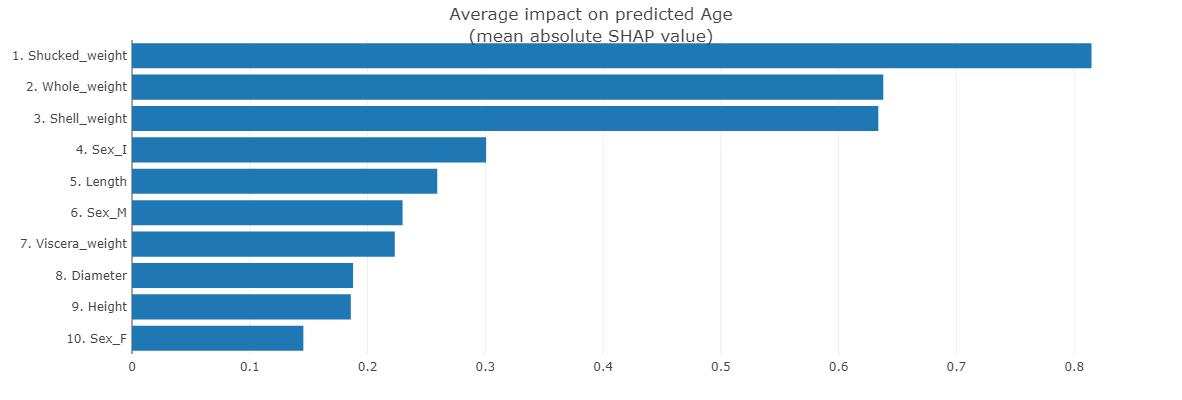

**Comments:**

Top 5 features that have impact on predicted Age are **Shucked weight, Whole weight, Shell weight, Sex_I** and **Length**.

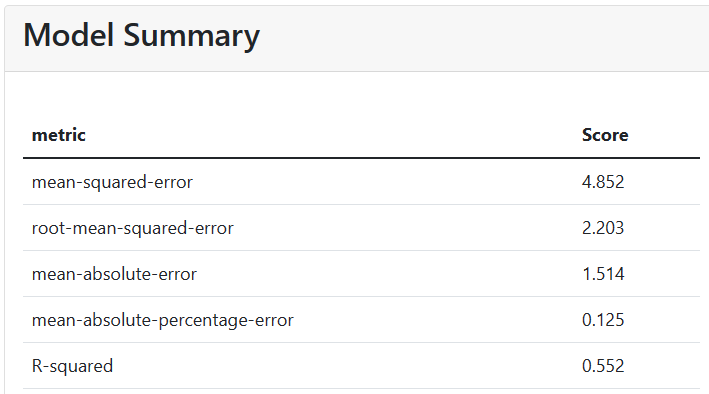

In [ ]:
residuals = y_test_full - svr_saved_preds

In [ ]:
residuals.describe()

count    836.000000
mean       0.180018
std        2.196573
min       -7.535519
25%       -1.093909
50%       -0.161770
75%        0.936215
max       13.025616
Name: Age, dtype: float64

In [ ]:
statistics.mode(residuals)

-2.5601031634399654

In [ ]:
df_resd = pd.DataFrame({'Residual': residuals})
df_preds = pd.DataFrame({'Age_preds': svr_saved_preds})
X_test_tr = X_test_transformed.drop(["Sex_F", "Sex_I", "Sex_M"], axis=1)
X_test_new = pd.concat((X_test_full['Sex'].reset_index(), X_test_tr,
                        y_test_full.reset_index(), df_preds, df_resd.reset_index()), axis=1)
X_test_new[:7]

In [ ]:
X_test_new.agg({"Age": ["min", "max", "median", "mean", "std", "sem", "skew"],
        "Age_preds": ["min", "max", "median", "mean", "std", "sem", "skew"],
        "Residual": ["min", "max", "median", "mean", "std", "sem", "skew"]})

,Age,Age_preds,Residual
min,4.500000,4.819527,-7.535519
max,24.500000,19.317991,13.025616
median,10.500000,11.248241,-0.161770
mean,11.389952,11.209935,0.180018
std,3.292138,2.335670,2.196573
sem,0.113861,0.080781,0.075970
skew,1.119329,0.079755,1.424882


In [ ]:
X_test_new.groupby('Sex')[['Age', 'Age_preds', 'Residual']].agg(["min", "max", "median", "mean", "std", "sem", "skew"]).T

Sex                       F          I          M
Age       min      6.500000   4.500000   6.500000
          max     24.500000  17.500000  24.500000
          median  11.500000   8.500000  11.500000
          mean    12.650538   8.969231  12.324916
          std      3.249614   2.131537   3.026290
          sem      0.194549   0.132192   0.175603
          skew     1.342908   0.753970   1.398933
Age_preds min      8.175180   4.819527   5.624456
          max     19.317991  15.854434  19.035519
          median  12.072003   8.986531  11.870914
          mean    12.282166   9.099624  12.050097
          std      1.785976   1.862470   1.911710
          sem      0.106924   0.115505   0.110929
          skew     0.962470   0.169080   0.528088
Residual  min     -5.817991  -4.834115  -7.535519
          max     13.025616   6.876708   9.706703
          median  -0.160887  -0.206095  -0.006106
          mean     0.368371  -0.130393   0.274819
          std      2.613090   1.387356   2.320907
          sem      0.156442   0.086040   0.134673
          skew     1.368851   0.991954   1.115797

**Comments:**

>

*   Mean Squared Error (**MSE**) measures the average of the squared differences between predicted values and actual target values.

  - By squaring the differences, the MSE places a higher weight on larger errors, making it sensitive to outliers.

  - Values lies between $0$ to $∞$ (small value indicates better model).

  - **MSE of 4.852** suggests that, on average, the predictions deviate from the actual values by approximately 4.852 units.

>

*   Root Mean Squared Error (**RMSE**) is the square root of MSE.

  - The RMSE represens the amount of error in the same unit as the predicted column.

  - Values lies between $0$ to $∞$ (small value indicates better model).

  - **RMSE of 2.203** implies that, on average, the predictions deviate from the actual values by around 2.203 units.

  - RMSE is less than the std of the target (y_test) and output (y_pred) variables, which is also good.

>

*   Mean Absolute Error (**MAE**) is measured as the average absolute difference between the predicted values and the actual values.

 - Treat larger and small errors equally, less sensitive to outliers.

 - Values lies between $0$ to $∞$ (small value indicates better model).

 - **MAE of 1.514** suggests that, on average, the predictions deviate from the actual values by approximately 1.514 units (years).

>

*   Mean Absolute Percentage Error (**MAPE**) is the percentage equivalent of mean absolute error (MAE).

 - The distribution of the absolute percentage errors is usually skewed to the right, with the presence of outlier values. In these cases, MAPE overstates the corresponding population parameter.

 - Values lies between $0$ to $∞$ (small value indicates better model).

 - **MAPE of 0.125** implies that, on average, the predictions are 12.5% off from the actual values (**which is a good forecasting by Lewis** (1982, p.40)).

>

*   R-Squared (**R2** or $R^{2}$) is a statistical measure used to determine the proportion of variance in a dependent variable that can be predicted or explained by an independent variable.

 - Values lies between 0 to 1 (value near 1 indicates better model).

 - **R2 of 0.552** suggests that more than half (55.2%) of the variance in the outcome variable is explained by the model.

###### References


https://mathblog.com/statistics/definitions/absolute-error/

https://www.mygreatlearning.com/blog/mean-square-error-explained/

https://arize.com/blog-course/mean-absolute-percentage-error-mape-what-you-need-to-know/

https://www.mishrark.com/machine-learning/3-regression/simple-linear-regression-in-python

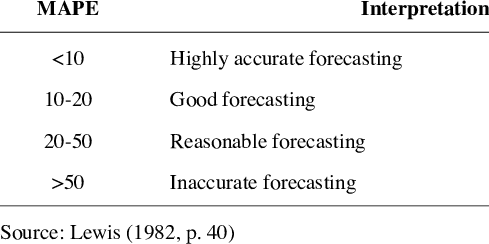

https://www.researchgate.net/publication/257812432_Using_the_R-MAPE_index_as_a_resistant_measure_of_forecast_accuracy

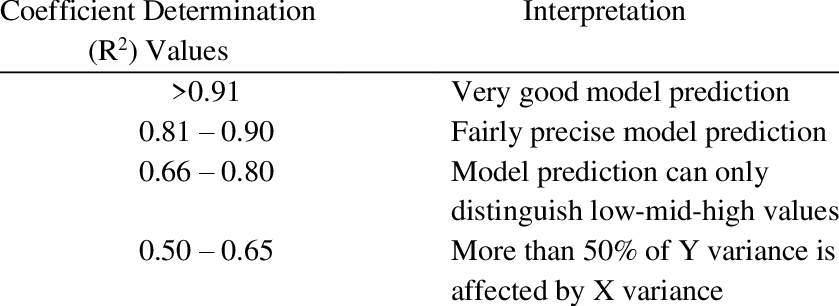

https://www.researchgate.net/publication/363886524_Predicting_sunlight_availability_for_vertical_shelves_using_simulation

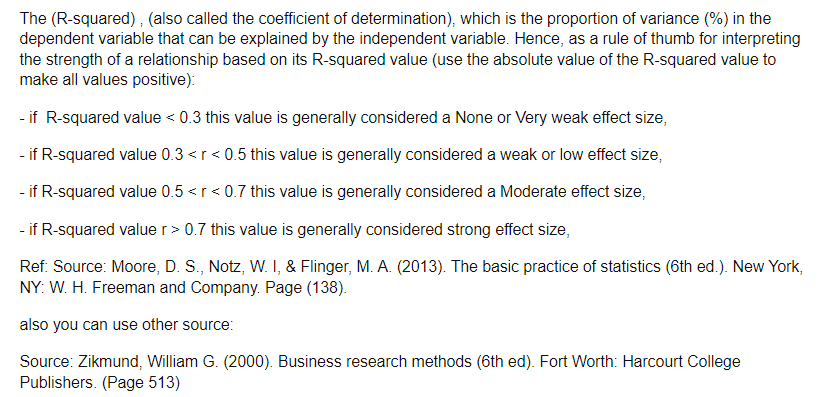

https://www.researchgate.net/post/What-is-the-acceptable-R-squared-in-the-information-system-research-Can-you-provide-some-references

##### Individual Predictions

###### Index 6

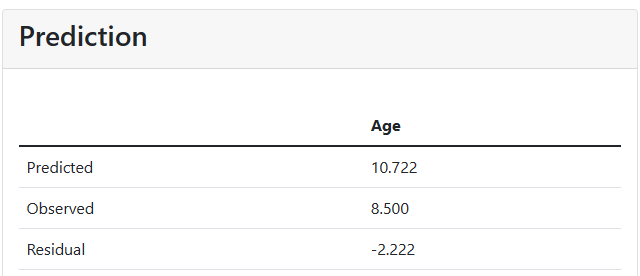

In [ ]:
df_test_full = pd.concat((X_test_full, y_test_full), axis=1)
df_test_full.head(7)

In [ ]:
y_test_full[6:7]

1590    8.5
Name: Age, dtype: float64

In [ ]:
df_test_full.iloc[6]

Sex                    I
Length              0.52
Diameter            0.39
Height              0.13
Whole_weight      0.5545
Shucked_weight    0.2355
Viscera_weight    0.1095
Shell_weight      0.1895
Age                  8.5
Name: 1590, dtype: object

**Comments:**

For this infant (I) individual the predicted age deviates from the observed by 2.222 years (predicted older than actual), this seems to be quite high.

Nevertheless, and if it can be compared, this residual does not exceed the std of the *target* (y_test_full: 3.292138) and *output* (y_pred: 2.3357) variables and slightly larger than the *residual std* (2.1966) for all genders in the test set.

Hovewer, it is higher than the std of the *target*, *output* and also *residual std* specifically for infants: 2.1315, 1.8625 and 1.3874, respectively.





**Contributions (High to Low)**

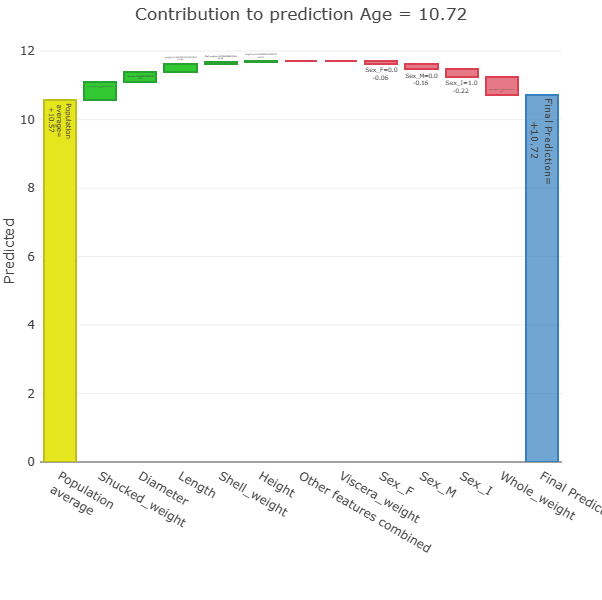

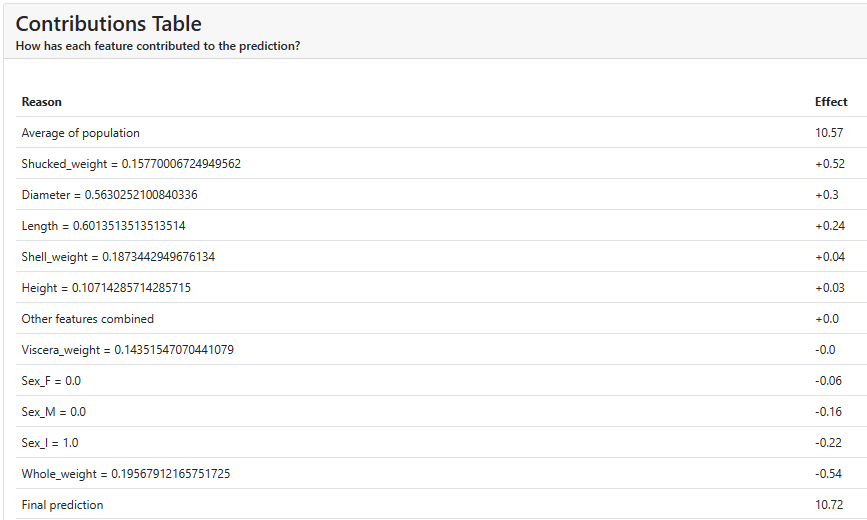

**Comments:**

Top 5 features that contributed to the prediction are **Shucked weight, Diameter, Length, Sex_I** and **Whole weight**.

###### Index 239

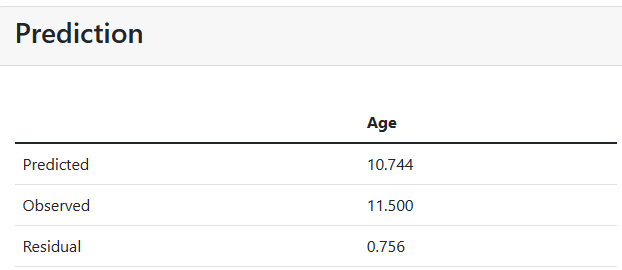

In [ ]:
y_test_full[239:240]

2781    11.5
Name: Age, dtype: float64

In [ ]:
df_test_full.iloc[239]

Sex                    M
Length             0.595
Diameter           0.475
Height              0.14
Whole_weight      1.0305
Shucked_weight    0.4925
Viscera_weight     0.217
Shell_weight       0.278
Age                 11.5
Name: 2781, dtype: object

**Comments:**

For this male (M) individual the predicted age deviates from the observed by 0.756 years (predicted younger than actual), which is not too far from the true value.

This residual does not exceed the std of the *target*, *output* and *residual std* for all genders, and also specifically for males in the test set.

**Contributions (High to Low)**

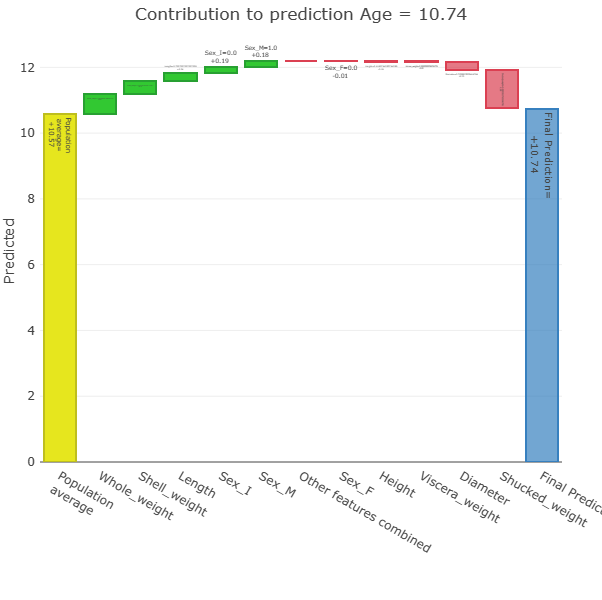

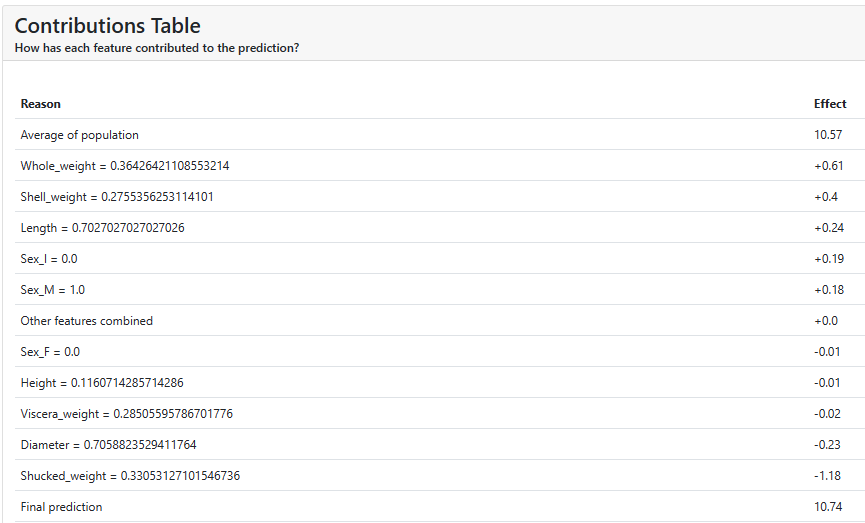

**Comments:**

Top 5 features that contributed to the prediction are **Whole weight, Shell weight, Length, Diameter** and **Shucked weight**.

###### Index 631

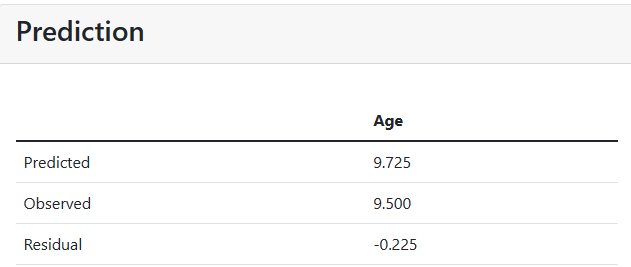

In [ ]:
y_test_full[631:632]

2647    9.5
Name: Age, dtype: float64

In [ ]:
df_test_full.iloc[631]

Sex                    I
Length               0.5
Diameter            0.39
Height             0.125
Whole_weight       0.583
Shucked_weight     0.294
Viscera_weight     0.132
Shell_weight      0.1605
Age                  9.5
Name: 2647, dtype: object

**Comments:**

For this infant (I) individual the predicted age deviates from the observed by 0.225 years (predicted slightly older than actual), which is quite close to the true value.

This residual does not exceed the std of the *target*, *output* and *residual std* for all genders, and also specifically for infants in the test set.

**Contributions (High to Low)**

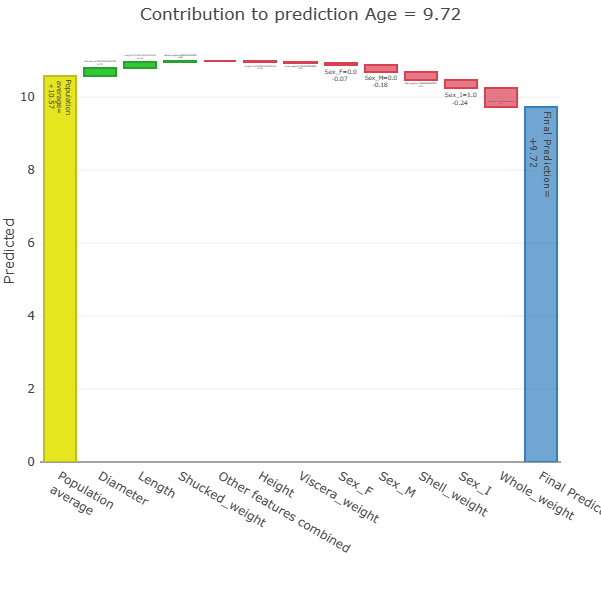

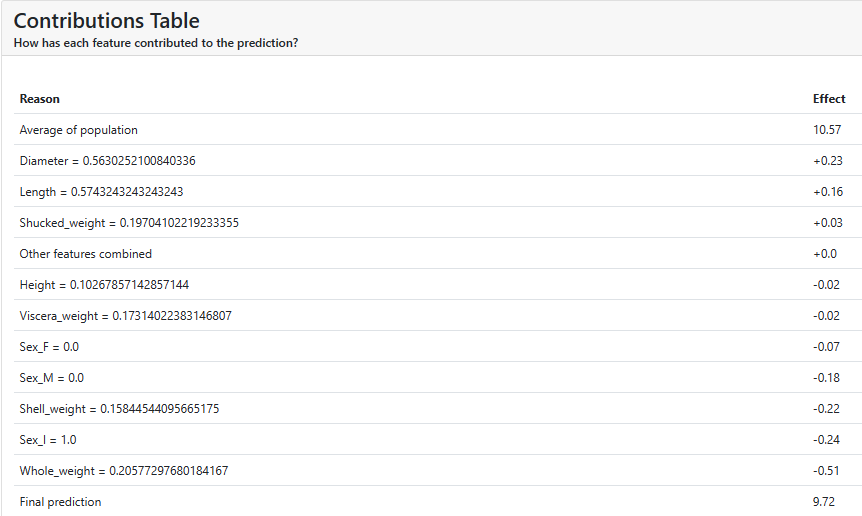

**Comments:**

Top 5 features that contributed to the prediction are **Diameter, Length, Shell weight, Sex_I** and **Whole weight**.

#### Modeling

**Best Model**

<Figure size 640x480 with 0 Axes>

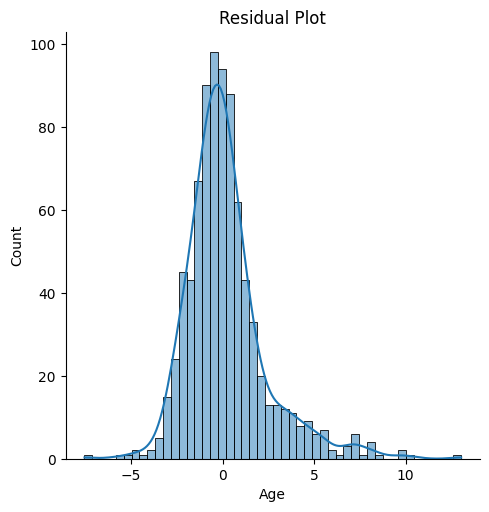

In [ ]:
plt.figure()
sns.displot(residuals, kde=True)
plt.title("Residual Plot")
plt.show()

**Positively Skewed Distribution**

Mean $>$ Median $>$ Mode

*   Tuned SVR performes better than KNN Regression and Random Forest Regression in both cases with and without categorical data. With categorical data ('Sex') the model evaluation is as follows:

 - **RMSE of 2.203** implies that, on average, the predictions deviate from the actual values by around 2.203 units (years).

 - **MAE of 1.514** suggests that, on average, the predictions deviate from the actual values by approximately 1.514 units (years).

 - **R2 of 0.552** suggests that more than half (55.2%) of the variance in the outcome variable is explained by the model.

---
So when predicting the age of abalone, the model deviates by approximately 2 years on average.

---

- The plot (above) shows that the residuals are asymmetrically distributed, as are almost all features in the dataset (shown in EDA), which causes the estimates to be biased.

  - The residuals range from -7.535519 to 13.025616 (Min - Max), this range looks huge, meaning that sometimes the model can predict the age of infants corresponding to adult species and vice versa ("Sex_I" (Infant) has the 4th highest impact on predicted age in the SHAP analysis).

---

Thus, the model performance can be evaluated as moderate to low.





**What can be improved...**



*   Data normalization.
*   Pre-processing of outliers (detected in EDA).
*   Analysis and more precise tuning of hyperparameters that affect the accuracy of the model.



**References:**

https://bigdevops.ru/article/dolzhno-li-znachenie-rmse-byt-menshe-standartnogo-otkloneniya

https://www.researchgate.net/publication/263726816_Root_Mean_Square_Error_Compared_to_and_Contrasted_with_Standard_Deviation

https://rpubs.com/Sergio_Garcia/sup_learning_regression

